In [8]:
%pip install torch
%pip install torchtext
%pip install scikit-learn
%pip install matplotlib
%pip install nltk
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch import nn, optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from collections import Counter
import nltk
from nltk import bigrams, trigrams
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.0/777.0 kB 46.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# **PART B**
Our chosen dataset is sms+spam+collection.
## **Q1: Problem Statement**
Our main objective is creating a machine learning model using the SMS Spam Collection dataset to efficiently classify text messages as spam or non-spam. This task is significant for improving mobile phone messaging experience for users, protecting them against unwanted content, and ensuring important messages are not mistakenly flagged as spam. Our approach includes following a standard NLP pipeline for data processing and cleaning, involving steps like punctuation removal and tokenization. We intend to establish a Support Vector Machine (SVM) model as a baseline and explore a neural network approach, specifically Convolutional Neural Network (CNN), for more advanced classification.

In [9]:
## read in data
columns = ['label','text']
data = pd.read_csv('SMSSpamCollection',sep='\t',header=None, names=columns)
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## **Q2: Datasets and Charts**
The SMS Spam Collection dataset comprises text messages categorized as 'spam' or 'ham' (non-spam). It includes SMS text messages from the Grumbletext website, the NUS SMS Corpus, and Caroline Tag's PhD Thesis. Each entry in the dataset has a label ('spam' or 'ham') followed by the message text content.


#### **Chart 1: Spam vs. Non-Spam Distribution Pie Chart**

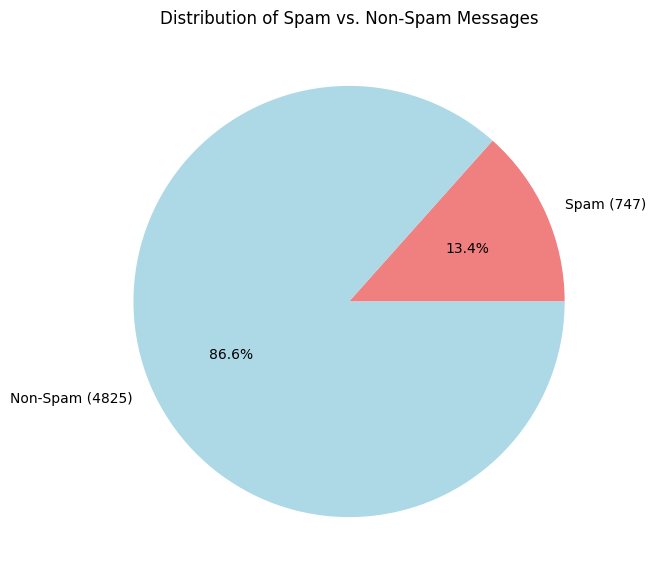

In [10]:
spam_count = data[data['label'] == 'spam'].shape[0]
ham_count = data[data['label'] == 'ham'].shape[0]
labels = [f'Spam ({spam_count})', f'Non-Spam ({ham_count})']

plt.figure(figsize=(7, 7))
plt.pie([spam_count, ham_count], labels=labels, colors=['lightcoral', 'lightblue'], autopct='%1.1f%%')

plt.title('Distribution of Spam vs. Non-Spam Messages')
plt.show()

Above pie chart highlights the overall distribution between spam and non-spam messages. From the chart, we observe that 13.4% (747 messages) of the dataset are spam while 86.6% (4825 messages) are non-spam. This visualization clearly demonstrates a significant imbalance in the data. Such imbalances can pose challenges in machine learning, particularly, the training model will spend most of its time on non-spam examples and not learn enough from spam ones. This chart underscores the need for us to apply some sampling techniques or other strategies to address the imbalance and thus improve our performance.

#### **Chart 2: Normalized Message Length Distribution Histogram**

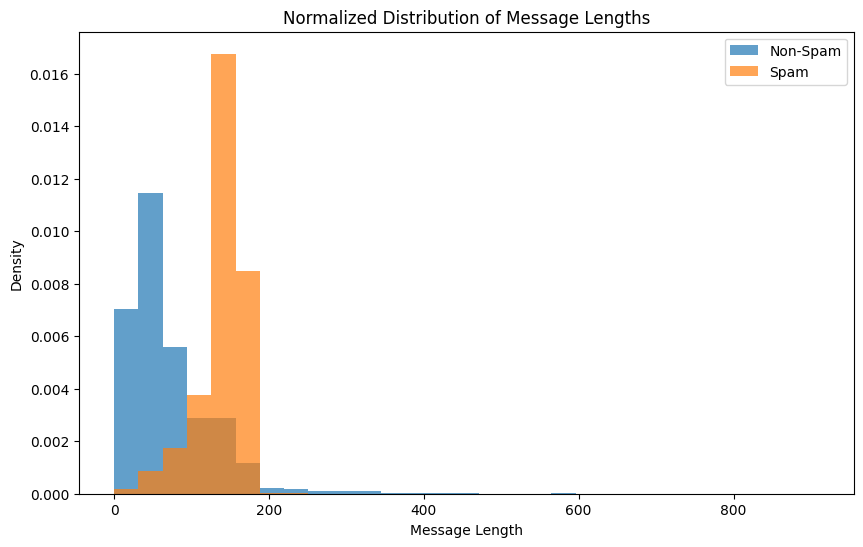

In [11]:
newdata = data
newdata['length'] = data['text'].map(lambda text: len(text))
spam = newdata[newdata['label'] == 'spam']['length']
ham = newdata[newdata['label'] == 'ham']['length']

bins = np.linspace(0, max(data['length']), 30)

plt.figure(figsize=(10, 6))
plt.hist(ham, bins=bins, alpha=0.7, label='Non-Spam', density=True)
plt.hist(spam, bins=bins, alpha=0.7, label='Spam', density=True)
plt.xlabel('Message Length')
plt.ylabel('Density')
plt.title('Normalized Distribution of Message Lengths')
plt.legend()
plt.show()

The histogram presented shows the normalized distribution of message lengths for spam and non-spam (ham) SMS messages. We created this visualization aiming to understand whether spam messages tend to be longer or shorter than non-spam messages, which can be an important feature for classification.

The non-spam messages (shown in blue) have most messages being shorter in length. The peak appears to be under 200 characters, indicating these texts tend to be concise. On the other hand, the spam messages (shown in orange) appear to be longer, with a significant spread between 200 and 400 characters. This suggests that spam messages might often be longer than non-spam messages, and this classification between these two classes could be correlated with the message length.

#### **Chart 3: Top Word Frequency in Entire Dataset/within Classes Bar Charts**

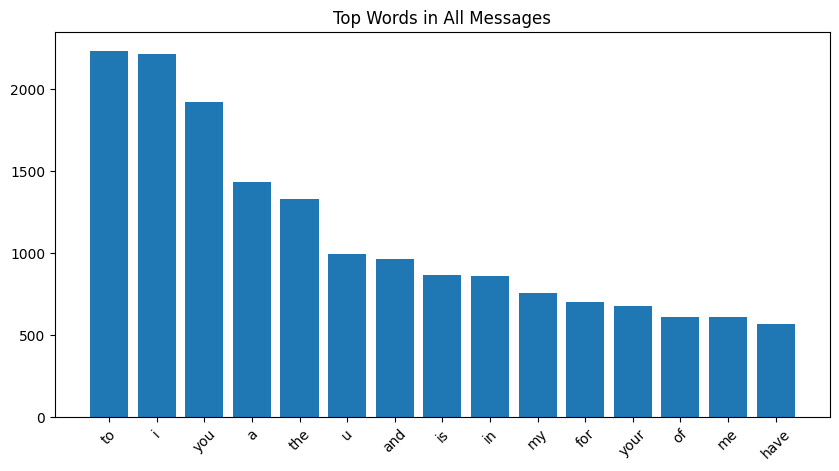

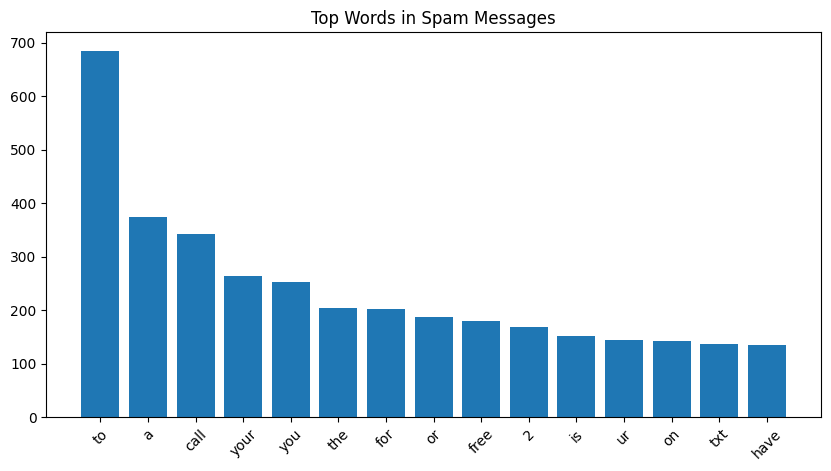

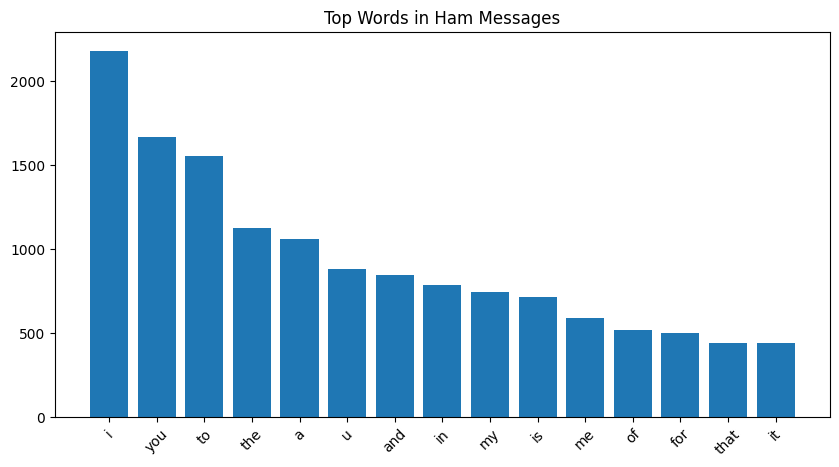

In [13]:
newdata['words'] = newdata['text'].apply(lambda x: x.lower().split())
all_words, spam_words, ham_words= [], [], []
for word_list in newdata['words']:
    all_words.extend(word_list)
for word_list in newdata[newdata['label'] == 'spam']['words']:
    spam_words.extend(word_list)
for word_list in newdata[newdata['label'] == 'ham']['words']:
    ham_words.extend(word_list)

word_counts_all = Counter(all_words)
word_counts_spam = Counter(spam_words)
word_counts_ham = Counter(ham_words)

def plot_word_freq(counter, title, n=15):
    most_common = counter.most_common(n)
    words, counts = [], []
    for word, count in most_common:
        words.append(word)
        counts.append(count)
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_word_freq(word_counts_all, 'Top Words in All Messages')
plot_word_freq(word_counts_spam, 'Top Words in Spam Messages')
plot_word_freq(word_counts_ham, 'Top Words in Ham Messages')

Above bar charts display the frequency of words across the entire datasets and within different classes of messages. These charts can be useful for feature selection. They highlight that common words, known as "stop words" (e.g., "the", "a", "and"), may not contribute to differentiating between message classes due to their high frequency across the board, especially those words appear to be most frequent in both of the classes. This observation suggests that more data processing is needed to remove these stop words (in our case: "to", "a", "you", "the", "for", "is").

#### **Chart 4: Proportion of Unique Words within Each Class Bar Chart**

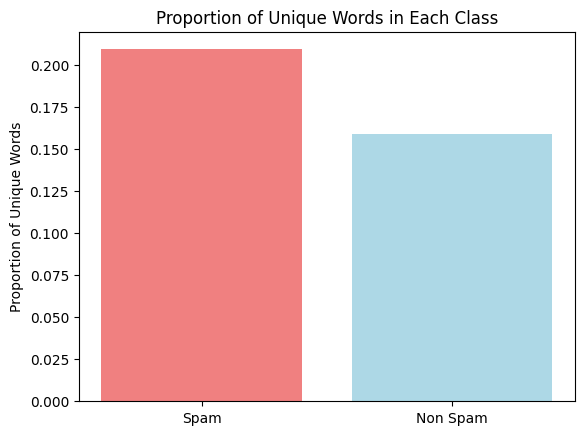

In [14]:
unique_words_spam = set(word for message in data[data['label'] == 'spam']['words'] for word in message)
unique_words_ham = set(word for message in data[data['label'] == 'ham']['words'] for word in message)

proportion_unique_spam = len(unique_words_spam) / len(spam_words)
proportion_unique_ham = len(unique_words_ham) / len(ham_words)

labels = ['Spam', 'Non Spam']
proportions = [proportion_unique_spam, proportion_unique_ham]

plt.bar(labels, proportions, color=['lightcoral', 'lightblue'])
plt.ylabel('Proportion of Unique Words')
plt.title('Proportion of Unique Words in Each Class')
plt.show()

Above bar chart displays the proportion of unique words in spam and non spam messages. The higher proportion of unique words in spam messages may suggest these messages use a wider variety of language or specific keywords to catch attention. Conversely, non spam messages might use a more consistent and limited vocabulary, likely reflecting everyday language. This difference indicates word uniquness might affect the spam vs. non spam classification.

#### **Chart 5: Top Trigram Frequency within Each Class Bar Chart**

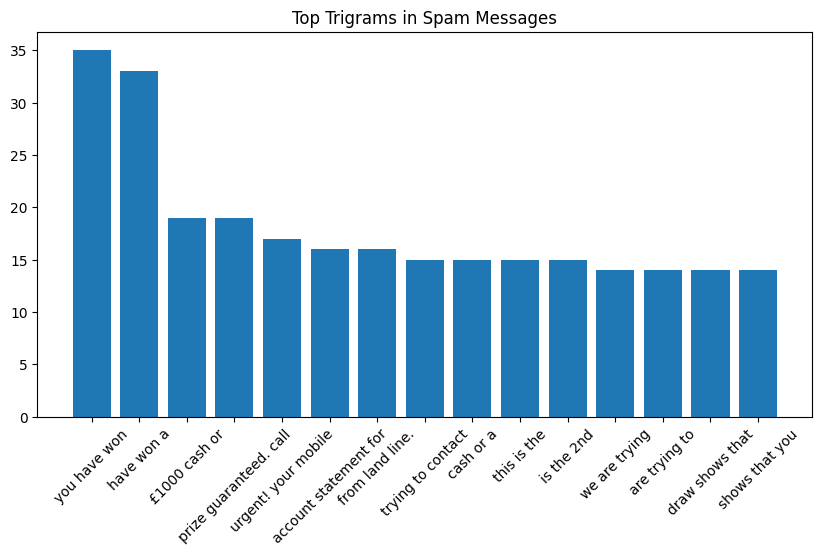

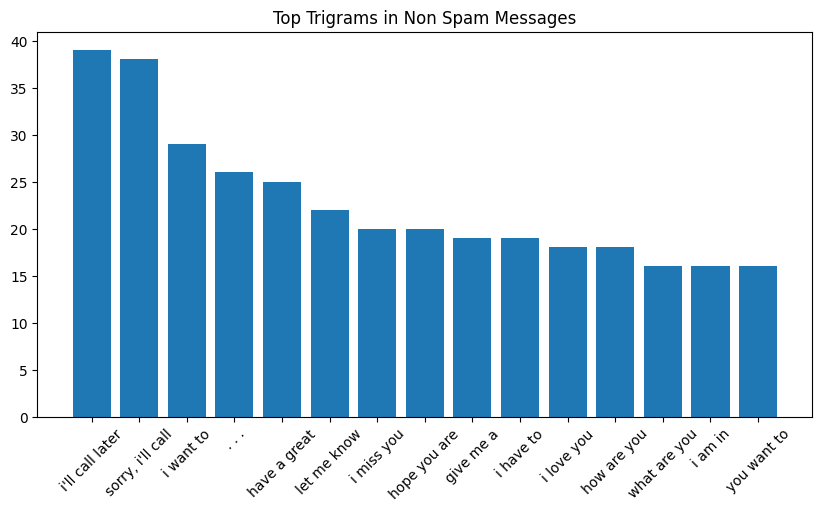

In [15]:
spam_words = newdata[newdata['label'] == 'spam']['words']
ham_words = newdata[newdata['label'] == 'ham']['words']

spam_trigrams = list(trigrams(word for message in spam_words for word in message))
ham_trigrams = list(trigrams(word for message in ham_words for word in message))

trigram_counts_spam = Counter(spam_trigrams)
trigram_counts_ham = Counter(ham_trigrams)

def plot_ngram_freq(counter, title, n=15):
    most_common = counter.most_common(n)
    ngrams = []
    counts = []
    for ngram, count in most_common:
        ngram_str = ' '.join(ngram)
        ngrams.append(ngram_str)
        counts.append(count)

    plt.figure(figsize=(10, 5))
    plt.bar(ngrams, counts)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_ngram_freq(trigram_counts_spam, 'Top Trigrams in Spam Messages')
plot_ngram_freq(trigram_counts_ham, 'Top Trigrams in Non Spam Messages')

Above two bar charts illustrate the frequency of the top trigrams in spam and non-spam messages. These trigrams make sense as the spam texts often have phrases like "you have won" or "urgent your mobile," which sound more like tricks. On the other hand, non-spam texts use everyday language such as "I'll call later" or "sorry I'll call," which are typical in normal conversations.

## **Q3: Data preprocessing**
Our first step involves converting the categorical labels into numerical form: spam messages are labeled as '1' and non-spam (ham) messages as '0'.

In [17]:
data = data[["label", "text"]]
data.loc[data["label"] == "spam", "label"] = 1
data.loc[data["label"] == "ham", "label"] = 0

We then process each text message in the dataset, each of them is converted to lowercase and tokenized. Stop words identified earlier including "to", "a", "you", "the", "for", and "is" are removed from these tokens.

In [18]:
def preprocess_text(text):
    # Tokenize text and convert to lower case
    words = text.lower().split()
    # Remove stop words
    stop_words = {"to", "a", "you", "the", "for", "is"}
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

data['text'] = data['text'].apply(preprocess_text)

We then splitting our dataset into train, validation and test set in a way that preserves the same proportions of examples in each class.
The ratio of the test sets are: 20% test data, 16% validation data and 64% test data.

In [19]:
data_list = data.values.tolist()
text_list = data["text"].tolist()
label_list = data["label"].tolist()
X_train, X_val_test, y_train, y_val_test = train_test_split(text_list, label_list, test_size=0.36, stratify = label_list, random_state=6)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=(20/36), stratify = y_val_test, random_state=6)
print(len(X_train), len(X_val), len(X_test))

3566 891 1115


We observed an imbalance on our dataset which could affect our model performance. Thus, we decide to use over sampling technique on our training data, specifically we will repeat some examples from the minority class to balance out the examples across the classes.

In [20]:
train_df = pd.DataFrame({'text': X_train, 'label': y_train})

df_majority = train_df[train_df["label"] == 0]
df_minority = train_df[train_df["label"] == 1]

# sample with replacement to match majority class size
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=123)

train_df = pd.concat([df_majority, df_minority_upsampled])
X_train = train_df['text']
y_train = train_df['label']
class_counts = train_df['label'].value_counts()
class_counts

label
0    3088
1    3088
Name: count, dtype: int64

## **Q4: Machine Learning Models**
### **Model 1: SVM with CountVectorizer**

Our first model is Support Vector Machine (SVM) with RBF kernel. We use CountVectorizer for feature extraction, making raw text into a format suitable for machine learning algorithms. This method counts the frequency of each word in the text, which serves as input features for the model. In addition, SVM is well-suited for binary classification problems, especially with high-dimensional data as in our case. The RBF kernel is particularly effective when the relationship between class labels and attributes is nonlinear, which is also like in our case.

In [21]:
cv = CountVectorizer()
SVM_X_train = cv.fit_transform(X_train)
SVM_X_test = cv.transform(X_test)
classifier = SVC(kernel = 'rbf')
classifier.fit(SVM_X_train, y_train)
score = classifier.score(SVM_X_test, y_test)
print("SVM prediction accuracy:", score)

SVM prediction accuracy: 0.9838565022421525


The reported accuracy of approximately 98.39% suggests that the SVM model performs very well on the test data. This high accuracy indicates that the model has successfully learned to distinguish between spam and non spam messages.

### **Model 2: CNN Model**
Although CNNs are commonly used in image processing, they also have great performance in NLP tasks. As CNN model can capture local dependencies and patterns in data, we chose to use CNN model, hoping it can learn relationships between words.

For feature extraction, GloVe embeddings are used to convert words into vectors, preserving semantic relationships. This helps in capturing contextual meanings in the text. The CNN model includes two convolutional layers with different kernel sizes and a linear layer for classification.

We created a custom dataset class to process our dataset for the neural network training. This class takes a GloVe vocabulary object and a pandas DataFrame as inputs. Inside the class, each text message is tokenized, each tokenized word is then mapped to an index based on the GloVe vocabulary. These indices are stored in tensors, which represent your input data (X), while the corresponding labels are stored in another tensor (Y).

In [22]:
#Tokenization, Word to Vector using Glove
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, df):
        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            words = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in words])) # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X
        self.Y = torch.tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [23]:
glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100
validation_df = pd.DataFrame({'text': X_val, 'label': y_val})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})
train_dataset = TextDataset(glove, train_df)
val_dataset = TextDataset(glove, validation_df)
test_dataset = TextDataset(glove, test_df)

.vector_cache/glove.6B.zip: 862MB [02:45, 5.22MB/s]                               
100%|█████████▉| 399999/400000 [00:20<00:00, 19495.25it/s]


In [24]:
# my_collate_function prepares batches and pads each sentence with zeroes if less than max length sentence in this batch.
def my_collate_function(batch):
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat([x, torch.zeros(max_len - len(x))])
        batch_x.append(x_p)
    return torch.stack(batch_x).int(), torch.tensor(batch_y)

batch_size = 16
train_dataloader = torch.utils.data.DataLoader(
      dataset=train_dataset,
      batch_size=batch_size,
      shuffle=False,
      collate_fn=lambda batch: my_collate_function(batch))

validation_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda batch: my_collate_function(batch))

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda batch: my_collate_function(batch))

In [25]:
class CNNModel(torch.nn.Module):
    def __init__(self, vocab, k1, k2, n1, n2, freeze=True):
        super().__init__()

        self.embedding = nn.Embedding.from_pretrained(vocab.vectors, freeze=freeze)
        embedding_size = len(vocab.vectors[0])
        # 1st convolution layer parameters(in_kernels, out_feature_maps, kernel_size)
        self.conv_1 = nn.Conv2d(1, n1, (k1, embedding_size), bias=False)
        # 2nd convolution layer
        self.conv_2 = nn.Conv2d(1, n2, (k2, embedding_size), bias=False)
        # final linear layer
        self.linear = nn.Linear(n1 + n2, 1)

    def forward(self, x):
        # x shape: (batch_size, sentence_len/word_indices_len(N))
        # embedding shape: (batch_size, N, embedding_size)
        # after squeeze: (batch_size, 1, N, embedding_size)
        x = self.embedding(x).unsqueeze(1)
        x1 = F.relu(self.conv_1(x))
        x2 = F.relu(self.conv_2(x))
        # apply maxpool over the output feature maps
        pool_1 = nn.MaxPool1d(x1.shape[2])
        pool_2 = nn.MaxPool1d(x2.shape[2])
        output_1 = pool_1(x1.squeeze(-1)).squeeze(-1)
        output_2 = pool_2(x2.squeeze(-1)).squeeze(-1)
        output = torch.cat((output_1, output_2), dim=1) # output shape: (batch_size, n1+n2)
        prediction = self.linear(output)
        return prediction

def train_CNN(vocab, train_dataloader, validation_dataloader, k1, k2, n1, n2, num_epochs=50, lr=0.001, freeze=True):
  num_epochs = num_epochs
  lr = lr

  model = CNNModel(vocab, k1, k2, n1, n2, freeze)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  # loss function
  criterion = nn.BCEWithLogitsLoss()

  train_accuracies, val_accuracies = [], []
  for epoch in range(num_epochs):
    model.train()
    train_correct_labels = 0.0
    num_training_examples = 0

    for word_indicies, labels in train_dataloader:
      optimizer.zero_grad()
      predictions = model.forward(word_indicies)
      predictions = predictions.to(torch.float32).squeeze()
      labels = labels.to(torch.float32)
      loss = criterion(predictions, labels)
      loss.backward()
      optimizer.step()
      # also need to calculate the accuracy
      # > 0.5 -> label 1 and <= 0.5 -> label 0
      predictions = torch.round(torch.sigmoid(predictions))
      num_training_examples += len(predictions)
      num_correct_labels = (predictions == labels).sum().item()
      train_correct_labels += num_correct_labels
    train_accuracies.append(train_correct_labels / num_training_examples)

    model.eval()
    val_correct_labels = 0.0
    num_validation_examples = 0
    with torch.no_grad():
      for word_indicies, labels in validation_dataloader:
        predictions = model.forward(word_indicies)
        predictions = predictions.to(torch.float32).squeeze()
        labels = labels.to(torch.float32)
        loss = criterion(predictions, labels)
        predictions = torch.round(torch.sigmoid(predictions))
        num_validation_examples += len(predictions)
        num_correct_labels = (predictions == labels).sum().item()
        val_correct_labels += num_correct_labels
    val_accuracies.append(val_correct_labels / num_validation_examples)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Accuracy: {train_accuracies[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}" )
  return model, train_accuracies, val_accuracies

In [29]:
model, train_accuracies, val_accuracies = train_CNN(glove, train_dataloader, validation_dataloader, k1 = 2, k2 = 4, n1 = 50, n2 = 40, lr = 0.002, num_epochs=50)

Epoch [1/50] - Train Accuracy: 0.9802, Validation Accuracy: 0.1336
Epoch [2/50] - Train Accuracy: 0.9466, Validation Accuracy: 0.1336
Epoch [3/50] - Train Accuracy: 0.9244, Validation Accuracy: 0.1336
Epoch [4/50] - Train Accuracy: 0.8967, Validation Accuracy: 0.1336
Epoch [5/50] - Train Accuracy: 0.9360, Validation Accuracy: 0.1336
Epoch [6/50] - Train Accuracy: 0.9487, Validation Accuracy: 0.1560
Epoch [7/50] - Train Accuracy: 0.9608, Validation Accuracy: 0.1336
Epoch [8/50] - Train Accuracy: 0.9665, Validation Accuracy: 0.1549
Epoch [9/50] - Train Accuracy: 0.9713, Validation Accuracy: 0.2155
Epoch [10/50] - Train Accuracy: 0.9773, Validation Accuracy: 0.1538
Epoch [11/50] - Train Accuracy: 0.9767, Validation Accuracy: 0.5836
Epoch [12/50] - Train Accuracy: 0.9853, Validation Accuracy: 0.7262
Epoch [13/50] - Train Accuracy: 0.9906, Validation Accuracy: 0.4164
Epoch [14/50] - Train Accuracy: 0.9895, Validation Accuracy: 0.7666
Epoch [15/50] - Train Accuracy: 0.9950, Validation Accura

Final Test Accuracy is 0.968609865470852


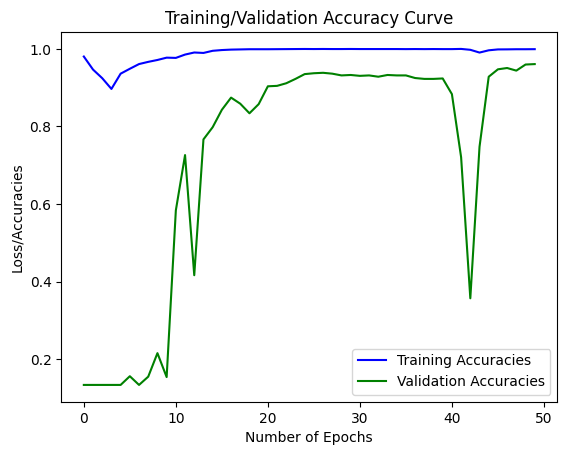

In [30]:
def compute_test_accuracy(model):
  model.eval()
  test_correct_labels = 0
  num_test_examples = 0
  with torch.no_grad():
    for word_indicies, labels in test_dataloader:
      predictions = model.forward(word_indicies).squeeze()
      predictions = torch.round(torch.sigmoid(predictions))
      num_test_examples += len(predictions)
      num_correct_labels = (predictions == labels).sum().item()
      test_correct_labels += num_correct_labels
  test_accuracy = test_correct_labels / num_test_examples
  print("Final Test Accuracy is", test_accuracy)
compute_test_accuracy(model)

fig, ax = plt.subplots()

# Plot training and validation losses
ax.plot(train_accuracies, 'b', label='Training Accuracies')
ax.plot(val_accuracies, 'g', label='Validation Accuracies')
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Loss/Accuracies')
ax.set_title('Training/Validation Accuracy Curve')
ax.legend()
plt.show()

The CNN model demonstrates a robust performance as the training and validation accuracy curves converging smoothly as the number of epochs increases except there's a small trough in between. This indicates a good fit to the data, with the final test accuracy reaching approximately 96.86%, which is also a very high accuracy.

Comparing this to the SVM's test accuracy of approximately 98.39%, the CNN's performance is slightly lower but still within a high range. Both models show excellent classification capabilities, while the SVM model achieves marginally higher accuracy with less computational complexity. This might because our spam detection dataset has relatively distinct differences between two classes, learning more complex patterns might not be neccessary.





